In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import statsmodels as sm
import polars as pl
import scipy
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures



from matplotlib.pyplot import tick_params

pl.enable_string_cache()
pl.Config.set_streaming_chunk_size(10000)

polars.config.Config

In [2]:
columns = ["Epoch", "Channel" ,"range_km", "Mag", "Track", "epsecs", "Satellite"]
N = 300000
lf = pl.scan_parquet("mmt.parquet").limit(n=N)
lf = lf.select(columns)

In [3]:
lf.collect()

Epoch,Channel,range_km,Mag,Track,epsecs,Satellite
"datetime[ms, UTC]",u8,f32,f32,u32,f32,u32
2014-08-17 01:07:10.153 UTC,7,1193.547485,4.91212,1576304,0.0,26118
2014-08-17 01:07:10.253 UTC,7,1193.628296,4.95134,1576304,0.1,26118
2014-08-17 01:07:10.353 UTC,7,1193.709473,4.88583,1576304,0.2,26118
2014-08-17 01:07:10.453 UTC,7,1193.791138,4.93736,1576304,0.3,26118
2014-08-17 01:07:10.553 UTC,7,1193.873291,4.99663,1576304,0.4,26118
…,…,…,…,…,…,…
2022-12-07 14:46:23.895 UTC,8,811.772949,8.11727,22123801,35.204002,54430
2022-12-07 14:46:24.095 UTC,8,811.349243,8.23247,22123801,35.404003,54430
2022-12-07 14:46:24.295 UTC,8,810.927917,8.63257,22123801,35.604,54430


In [4]:
df = pl.DataFrame(lf.collect())
print(df.describe(interpolation="linear"))

shape: (9, 8)
┌────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ statistic  ┆ Epoch      ┆ Channel    ┆ range_km  ┆ Mag       ┆ Track     ┆ epsecs    ┆ Satellite │
│ ---        ┆ ---        ┆ ---        ┆ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ str        ┆ str        ┆ f64        ┆ f64       ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ count      ┆ 278633498  ┆ 2.78633498 ┆ 2.7863349 ┆ 2.7863349 ┆ 2.7863349 ┆ 2.7863349 ┆ 2.7863349 │
│            ┆            ┆ e8         ┆ 8e8       ┆ 8e8       ┆ 8e8       ┆ 8e8       ┆ 8e8       │
│ null_count ┆ 0          ┆ 0.0        ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0       │
│ mean       ┆ 2020-04-06 ┆ 4.950507   ┆ 7644.3632 ┆ 7.562363  ┆ 1.7603e7  ┆ 384.47622 ┆ 32638.023 │
│            ┆ 23:05:40.6 ┆            ┆ 81        ┆           ┆           ┆ 

###  Observations
The minimum brightness was (Negative logarithm of -3.01918) = undefined? something is going on here


## Handling Outliers

KeyboardInterrupt: 

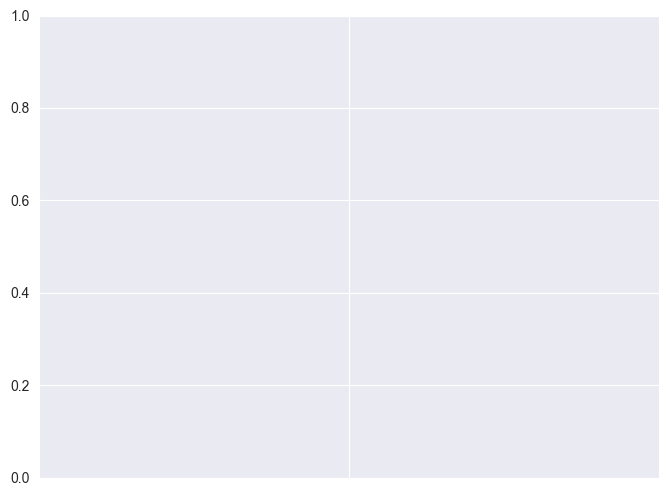

In [5]:
outliers_data = []
for col in df.columns[1:]:
    q1 = df.get_column(col).quantile(0.25)
    q3 = df.get_column(col).quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers_col = df.filter(
        (df.get_column(col) < lower_bound) | (df.get_column(col) > upper_bound)
    )
    outliers_col = outliers_col.with_columns(pl.lit(col).alias("outlier_column"))
    outliers_data.append(outliers_col)
    plt.figure(figsize=(8, 6))
    sns.boxplot(
        y=df.get_column(col),
        color="skyblue",
        flierprops={'marker': 'o', 'markersize': 8, 'markerfacecolor': 'red'},
        boxprops={'linewidth': 2},
        whiskerprops={'linewidth': 2},
        capprops={'linewidth': 2},
        medianprops={'color': 'black', 'linewidth': 2}
    )
    plt.title(f'Boxplot of {col}', fontsize=14)
    plt.ylabel(col, fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

outliers = pl.concat(outliers_data)

In [124]:
# DF of outliers
outliers

Epoch,Channel,range_km,Mag,Track,epsecs,Satellite,outlier_column
"datetime[ms, UTC]",u8,f32,f32,u32,f32,u32,str
2015-09-23 23:56:45.296 UTC,3,5048.277344,8.97623,8898923,0.0,16483,"""range_km"""
2015-09-23 23:56:45.396 UTC,3,5048.724609,9.74084,8898923,0.1,16483,"""range_km"""
2015-09-23 23:56:45.496 UTC,3,5049.172363,9.04988,8898923,0.2,16483,"""range_km"""
2015-09-23 23:56:45.596 UTC,3,5049.620117,9.62345,8898923,0.3,16483,"""range_km"""
2015-09-23 23:56:45.696 UTC,3,5050.067871,9.54469,8898923,0.4,16483,"""range_km"""
…,…,…,…,…,…,…,…
2024-11-06 02:15:51.895 UTC,4,1232.122314,9.38871,30013631,49.195004,424,"""Satellite"""
2024-11-06 02:15:52.395 UTC,4,1233.345825,9.58219,30013631,49.695004,424,"""Satellite"""
2024-11-06 02:15:52.895 UTC,4,1234.577271,9.68021,30013631,50.195004,424,"""Satellite"""


## Observations of the Boxplots

# Finding the correlation between features

In [1]:
df.drop("Epoch")
print(df.corr())
plt.figure(figsize=(11,8))

sns.heatmap(df.corr(), cmap="seismic", annot=True, xticklabels=df.columns, yticklabels=df.columns)

NameError: name 'df' is not defined

## Make some observations here
search how to read correlation maps

In [126]:
df = df.with_columns(pl.col("Epoch").cast(pl.Datetime))
first_date = df.select(pl.col("Epoch").min()).to_series().item()
df = df.with_columns(((pl.col("Epoch").cast(pl.Int64) - first_date.timestamp()) / 86400).alias("days_since"))
print(df)

shape: (3_000_000, 8)
┌──────────────┬─────────┬─────────────┬─────────┬──────────┬────────┬───────────┬────────────┐
│ Epoch        ┆ Channel ┆ range_km    ┆ Mag     ┆ Track    ┆ epsecs ┆ Satellite ┆ days_since │
│ ---          ┆ ---     ┆ ---         ┆ ---     ┆ ---      ┆ ---    ┆ ---       ┆ ---        │
│ datetime[μs] ┆ u8      ┆ f32         ┆ f32     ┆ u32      ┆ f32    ┆ u32       ┆ f64        │
╞══════════════╪═════════╪═════════════╪═════════╪══════════╪════════╪═══════════╪════════════╡
│ 2014-08-17   ┆ 7       ┆ 1193.547485 ┆ 4.91212 ┆ 1576304  ┆ 0.0    ┆ 26118     ┆ 1.6299e10  │
│ 01:07:10.153 ┆         ┆             ┆         ┆          ┆        ┆           ┆            │
│ 2014-08-17   ┆ 7       ┆ 1193.628296 ┆ 4.95134 ┆ 1576304  ┆ 0.1    ┆ 26118     ┆ 1.6299e10  │
│ 01:07:10.253 ┆         ┆             ┆         ┆          ┆        ┆           ┆            │
│ 2014-08-17   ┆ 7       ┆ 1193.709473 ┆ 4.88583 ┆ 1576304  ┆ 0.2    ┆ 26118     ┆ 1.6299e10  │
│ 01:07:10.353 ┆  

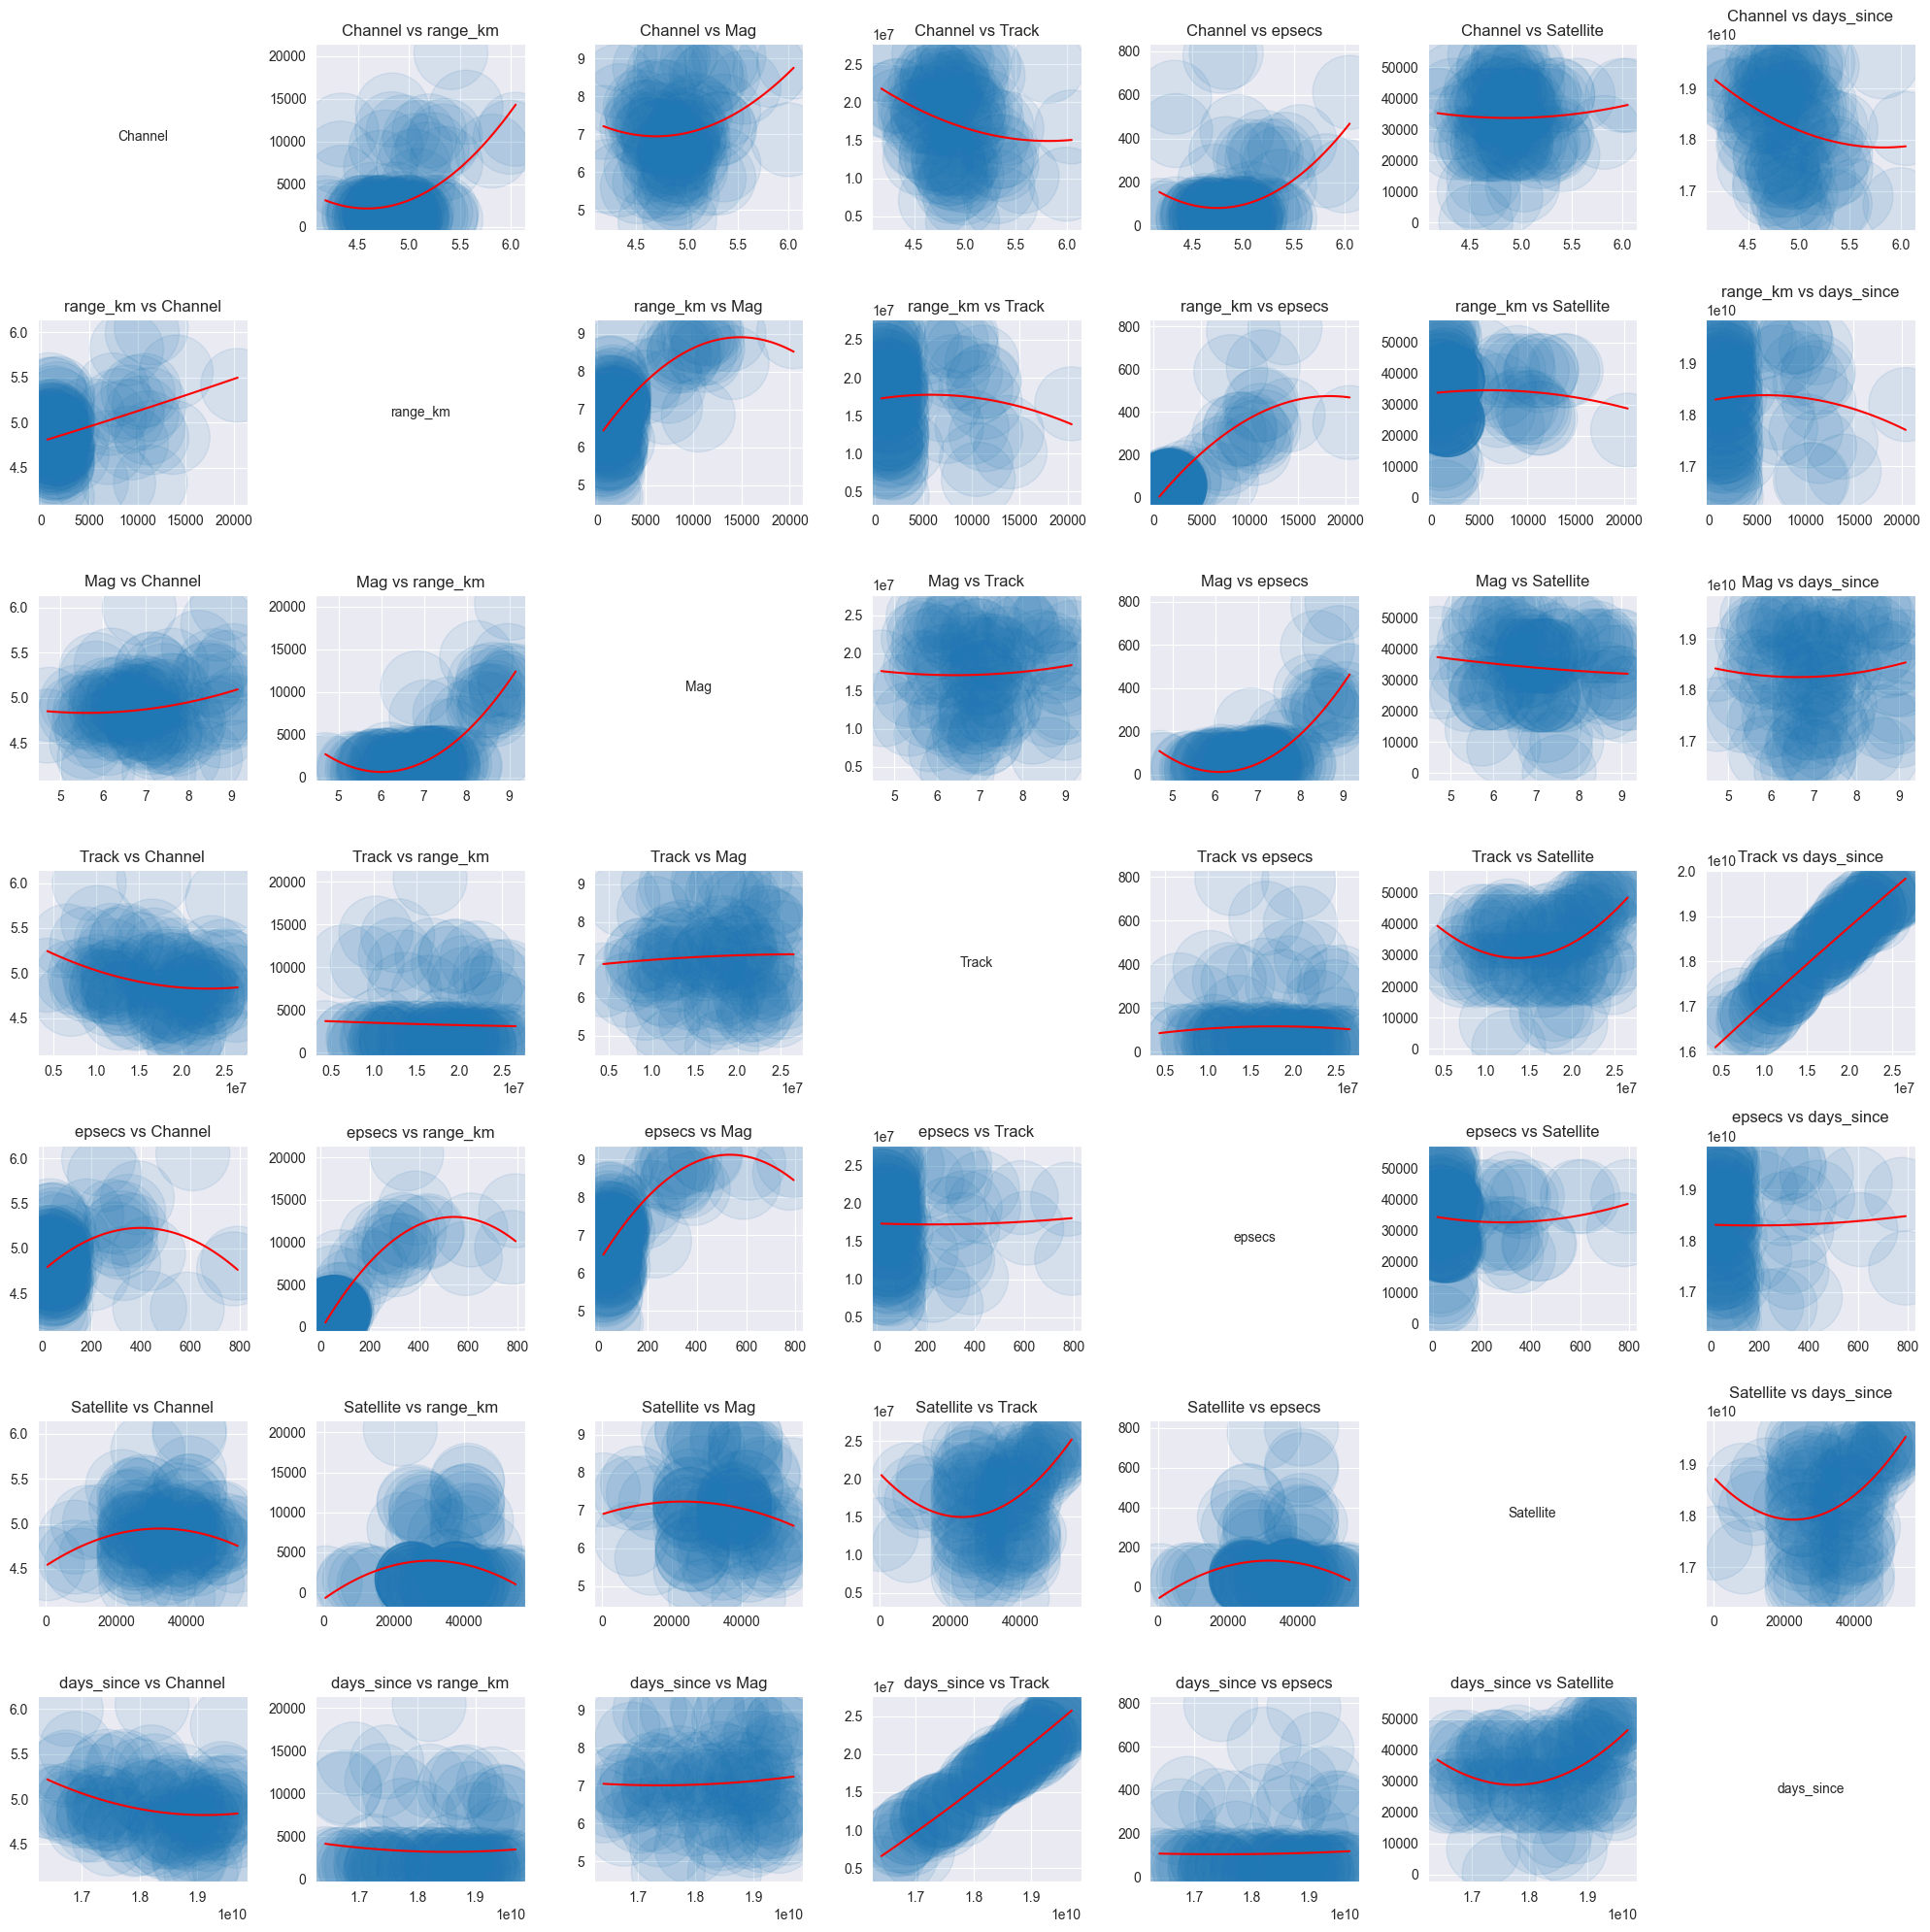

In [127]:
downsample_rate = 10000

def plot_reduced_df(df, downsample_rate):
    columns = df.columns[1:]
    n = len(columns)

    fig, axes = plt.subplots(nrows=n, ncols=n, figsize=(20, 20))

    for i, col1 in enumerate(columns):
        for j, col2 in enumerate(columns):
            if i != j:
                total_rows = df.shape[0]
                num_bins = min(downsample_rate, total_rows)
                df_slice = df.head(total_rows)
                bin_edges = np.linspace(0, total_rows, num_bins + 1, dtype=int)

                binned_col1 = []
                binned_col2 = []
                bin_weights = []

                for k in range(num_bins):
                    start, end = bin_edges[k], bin_edges[k+1]
                    slices = df_slice[start:end]

                    bin_weight = len(slices)

                    bin_avg_col1 = slices[col1].mean()
                    bin_avg_col2 = slices[col2].mean()

                    binned_col1.append(bin_avg_col1)
                    binned_col2.append(bin_avg_col2)
                    bin_weights.append(bin_weight)

                X = np.array(binned_col1).reshape(-1, 1)
                y = np.array(binned_col2)
                weights = np.array(bin_weights)

                poly_features = PolynomialFeatures(degree=2)
                X_poly = poly_features.fit_transform(X)

                reg = LinearRegression().fit(X_poly, y, sample_weight=weights)

                X_curve = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
                X_curve_poly = poly_features.transform(X_curve)
                y_curve = reg.predict(X_curve_poly)

                # Plot
                axes[i][j].scatter(binned_col1, binned_col2, alpha=0.1, s=weights/10)
                axes[i][j].plot(X_curve, y_curve, color='red')
                axes[i][j].set_title(f'{col1} vs {col2}')

            else:
                axes[i][j].text(0.5, 0.5, col1,
                                horizontalalignment='center',
                                verticalalignment='center')
                axes[i][j].axis('off')

    plt.tight_layout()
    plt.show()

plot_reduced_df(df, downsample_rate)

## Missing Values

In [128]:
df.null_count()

Epoch,Channel,range_km,Mag,Track,epsecs,Satellite,days_since
u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0


No missing values.

### Determining the features of channels and how it correlates with other features.

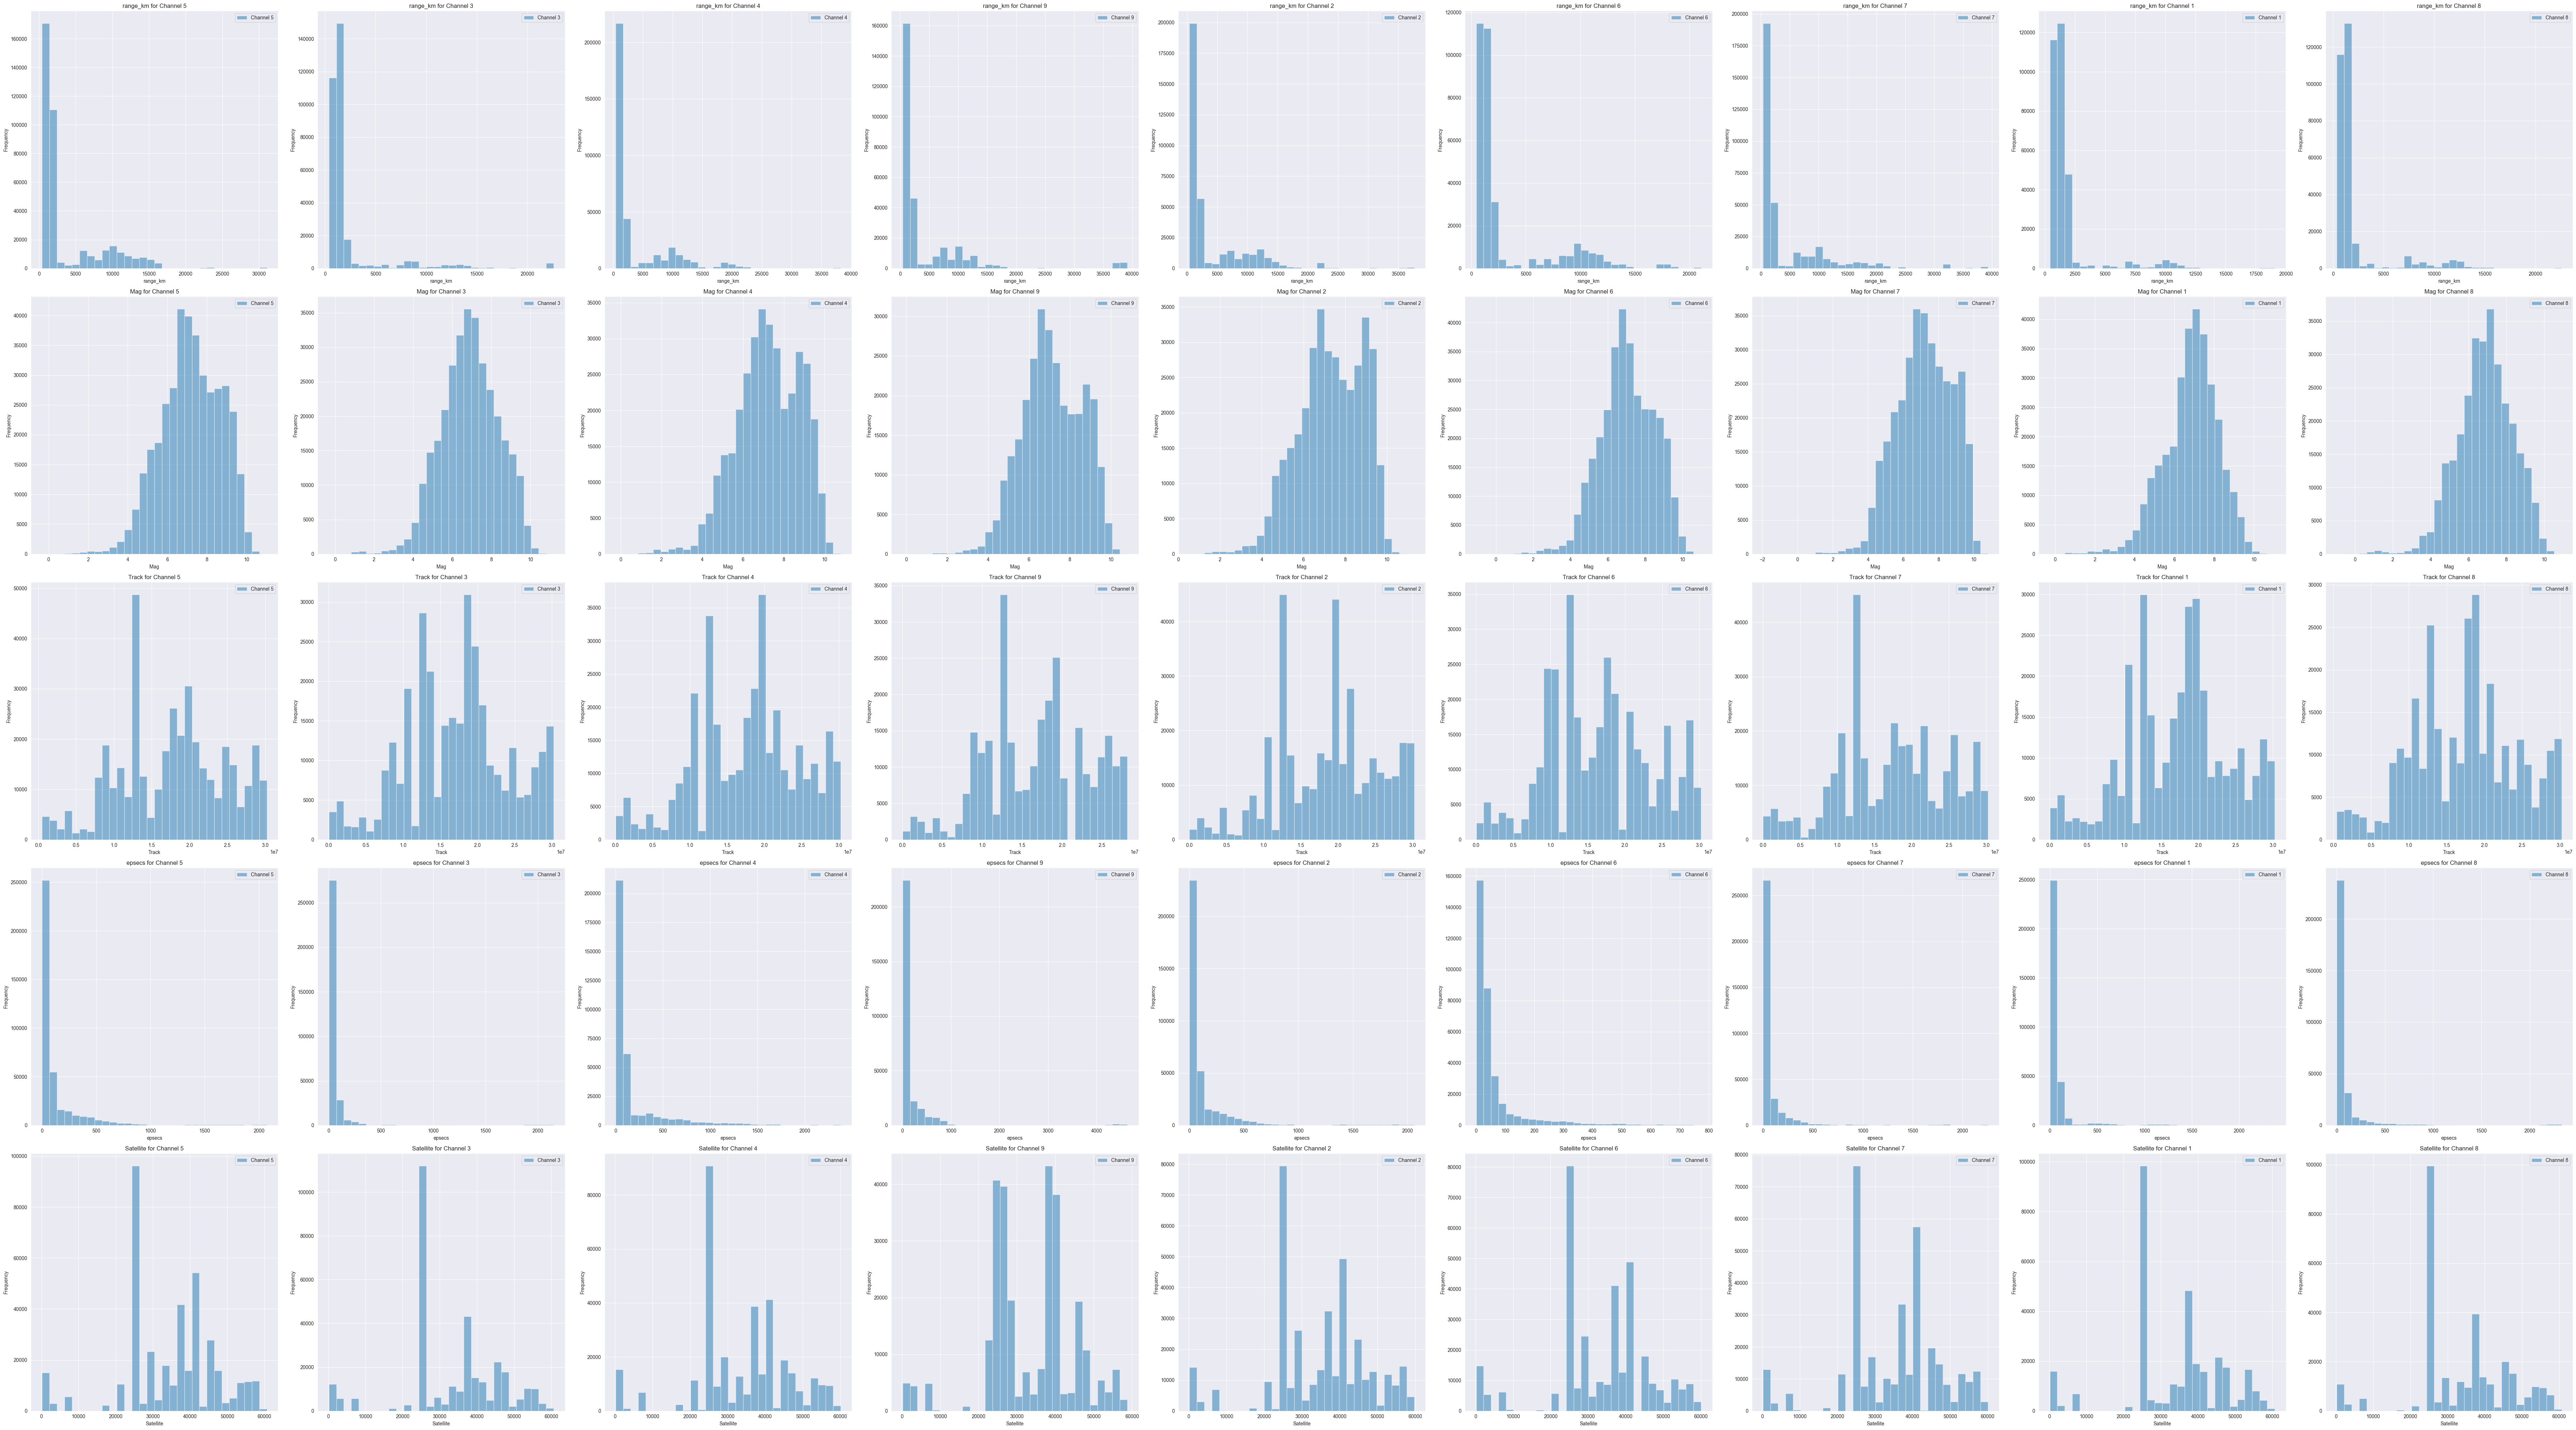

In [129]:
df = df.with_columns(pl.col("Channel").cast(pl.Utf8))

# Features to analyze
features = ["range_km", "Mag", "Track", "epsecs", "Satellite"]

# Group by 'Channel' and calculate the mean of each feature
summary_stats = df.group_by("Channel").agg(
    [pl.col(feature).mean().alias(f"{feature}_mean") for feature in features]
)

# Get the unique channels
channels = summary_stats.select("Channel").to_series()

# Create a square plot with subplots for each feature grouped by channel
num_features = len(features)
num_channels = len(channels)
fig, axes = plt.subplots(nrows=num_features, ncols=num_channels, figsize=(8 * num_channels, 8 * num_features))

for i, feature in enumerate(features):
    for j, channel in enumerate(channels):
        channel_data = df.filter(pl.col("Channel") == channel).select(feature).to_series()
        axes[i, j].hist(channel_data, bins=30, alpha=0.5, label=f'Channel {channel}')
        axes[i, j].set_title(f'{feature} for Channel {channel}')
        axes[i, j].set_xlabel(feature)
        axes[i, j].set_ylabel('Frequency')
        axes[i, j].legend()

plt.tight_layout()
plt.show()

In [130]:
df = df.with_columns(pl.col("Channel").cast(pl.Utf8))

features = ["range_km", "Mag", "Track", "epsecs", "Satellite"]
summary_stats = df.group_by("Channel").agg(
    [pl.col(feature).mean().alias(f"{feature}_mean") for feature in features] +
    [pl.col(feature).std().alias(f"{feature}_std") for feature in features]
)

print(summary_stats)

shape: (9, 11)
┌─────────┬────────────┬──────────┬────────────┬───┬──────────┬───────────┬────────────┬───────────┐
│ Channel ┆ range_km_m ┆ Mag_mean ┆ Track_mean ┆ … ┆ Mag_std  ┆ Track_std ┆ epsecs_std ┆ Satellite │
│ ---     ┆ ean        ┆ ---      ┆ ---        ┆   ┆ ---      ┆ ---       ┆ ---        ┆ _std      │
│ str     ┆ ---        ┆ f32      ┆ f64        ┆   ┆ f32      ┆ f64       ┆ f32        ┆ ---       │
│         ┆ f32        ┆          ┆            ┆   ┆          ┆           ┆            ┆ f64       │
╞═════════╪════════════╪══════════╪════════════╪═══╪══════════╪═══════════╪════════════╪═══════════╡
│ 7       ┆ 4423.81152 ┆ 7.184626 ┆ 1.7263e7   ┆ … ┆ 1.547127 ┆ 7.2520e6  ┆ 242.102295 ┆ 12903.847 │
│         ┆ 3          ┆          ┆            ┆   ┆          ┆           ┆            ┆ 964       │
│ 6       ┆ 3205.80737 ┆ 7.050601 ┆ 1.6562e7   ┆ … ┆ 1.442297 ┆ 7.0565e6  ┆ 101.757507 ┆ 13033.028 │
│         ┆ 3          ┆          ┆            ┆   ┆          ┆           ┆ 

### Observations
Channel seems to only effect range km 